## GLO Comparison of HWMs and HEC-RAS Results

This Jupyter notebook aims to analyze and compare high water marks (HWMs) and HEC-RAS simulation results. The main objectives of this notebook are:

Data Preprocessing: Load and preprocess the geographic and simulation data for comparison.
Data Matching: Match observed HWMs with corresponding HEC-RAS maximum water surface elevation (WSE) values.
Statistical Analysis: Perform statistical analysis to understand the correlation between HWMs and HEC-RAS results.
Visualization: Create visualizations to illustrate the relationship between observed and simulated data, including scatter plots and linear regression analysis.
The notebook is structured as follows:

Introduction: Provides an overview of the data and the purpose of the analysis.
Data Loading: Code for loading the necessary data files, including geographic and HEC-RAS results.
Data Preprocessing: Steps to clean and prepare the data for analysis.
Data Matching: Process of matching observed HWMs with HEC-RAS results based on geographic proximity.
Statistical Analysis: Calculating correlation coefficients and performing linear regression to quantify the relationship between observed and simulated data.
Visualization: Generating plots to visualize the comparison, including scatter plots and trend lines.

## Extract the Raster values and write it in the shp

In [2]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point, box
import numpy as np

# Define file paths
input_shapefile = r"S:\For_Angshuman\GLO\HECRASV6.5_BaseModel\Extracted_Harvey_at_HWM_locations.shp"
input_raster = r"S:\For_Angshuman\GLO\HEC-RASV6.5_NewBaseModel\HECRASV6.5_BaseModel\Harvey_ICWW_Wind\HarveyNEW_WSE_Max.Terrain.cudem_ft.tif"
output_shapefile = r"S:\For_Angshuman\GLO\HEC-RASV6.5_NewBaseModel\HECRASV6.5_BaseModel\Output_Extracted_Harvey_at_HWM_locations.shp"

# Load the shapefile
shapefile_gdf = gpd.read_file(input_shapefile)

# Open the raster file
with rasterio.open(input_raster) as src:
    # Print CRS for debugging
    print(f"Shapefile CRS: {shapefile_gdf.crs}")
    print(f"Raster CRS: {src.crs}")

    # Ensure the CRS of the shapefile matches the raster
    if shapefile_gdf.crs != src.crs:
        shapefile_gdf = shapefile_gdf.to_crs(src.crs)

    # Print CRS after transformation for debugging
    print(f"Transformed Shapefile CRS: {shapefile_gdf.crs}")

    # Get raster dimensions and transform
    transform = src.transform
    raster_array = src.read(1)
    raster_width = src.width
    raster_height = src.height

    # Create a bounding box for the raster
    raster_bounds = box(*src.bounds)

    # Print raster bounds for debugging
    print(f"Raster bounds: {src.bounds}")

    # Create a list to store raster values
    raster_values = []

    # Iterate over the shapefile points
    for point in shapefile_gdf.geometry:
        # Ensure the point is a shapely Point
        if not isinstance(point, Point):
            point = Point(point)

        # Check if the point is within the raster bounds
        if point.within(raster_bounds):
            # Get the row and column index of the point
            row, col = src.index(point.x, point.y)

            # Check if the point is within the raster bounds
            if 0 <= row < raster_height and 0 <= col < raster_width:
                raster_value = raster_array[row, col]
                if np.isnan(raster_value):
                    raster_value = None  # Handle NoData values
            else:
                raster_value = None  # Assign None for points outside raster bounds

            raster_values.append(raster_value)

            # Debugging output
            print(f"Point ({point.x}, {point.y}) -> Row: {row}, Col: {col}, Value: {raster_value}")
        else:
            print(f"Point ({point.x}, {point.y}) is out of raster bounds.")
            raster_values.append(None)

# Add the raster values to the shapefile's dataframe
shapefile_gdf['RASTERVALU'] = raster_values

# Save the updated shapefile
shapefile_gdf.to_file(output_shapefile)

print("Raster values extracted and saved to new shapefile.")


Shapefile CRS: EPSG:2278
Raster CRS: PROJCS["NAD_1983_TCMS_Albers_FtUS",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",18],PARAMETER["longitude_of_center",-100],PARAMETER["standard_parallel_1",27.5],PARAMETER["standard_parallel_2",35],PARAMETER["false_easting",4921250],PARAMETER["false_northing",19685000],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Transformed Shapefile CRS: PROJCS["NAD_1983_TCMS_Albers_FtUS",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","

# Comparison of HWMs and HEC-RAS Model Results for Harvey

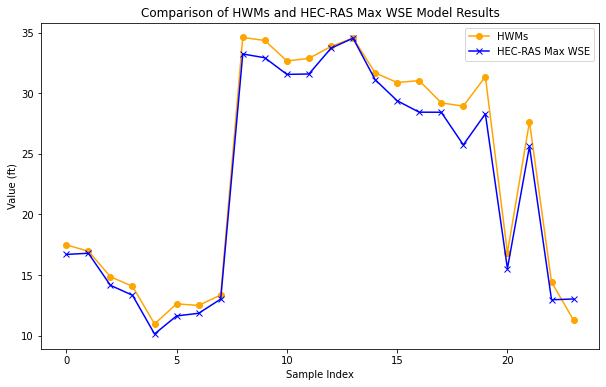

In [12]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os

# Load the shapefile
shapefile_path = "S:\For_Angshuman\GLO\HEC-RASV6.5_NewBaseModel\HECRASV6.5_BaseModel\Output_Extracted_Harvey_at_HWM_locations.shp"
gdf = gpd.read_file(shapefile_path)

# Manually replace -9999 with NaN in the specific columns
gdf['Field4'] = gdf['Field4'].apply(lambda x: pd.NA if x == -9999 else x)
gdf['RASTERVALU'] = gdf['RASTERVALU'].apply(lambda x: pd.NA if x == -9999 else x)

# Drop NaN values for accurate statistics
matched_gdf = gdf.dropna(subset=['Field4', 'RASTERVALU'])

# Prepare the data for linear regression
x = matched_gdf['RASTERVALU'].values.reshape(-1, 1)
y = matched_gdf['Field4'].values

# Create the plot
plt.figure(figsize=(10, 6))

# Plot HWM values
plt.plot(y, label='HWMs', marker='o', linestyle='-', color='orange')

# Plot HEC-RAS values
plt.plot(x, label='HEC-RAS Max WSE', marker='x', linestyle='-', color='blue')

# Adding titles and labels
plot_title = 'Comparison of HWMs and HEC-RAS Max WSE Model Results'
plt.title(plot_title)
plt.xlabel('Sample Index')
plt.ylabel('Value (ft)')
plt.legend()
plt.grid(False)



# Show the plot
plt.show()

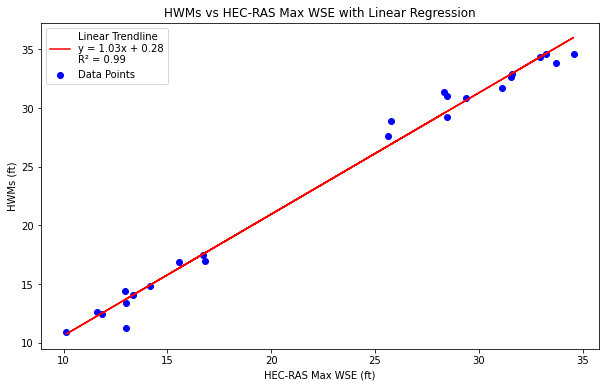

In [4]:
# Drop NaN values for accurate statistics
matched_gdf = gdf.dropna(subset=['Field4', 'RASTERVALU'])

# Prepare the data for linear regression
x = matched_gdf['RASTERVALU'].values.reshape(-1, 1)
y = matched_gdf['Field4'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Get the linear regression line
y_pred = model.predict(x)

# Calculate the R² value
r2 = r2_score(y, y_pred)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(x, y, label='Data Points', color='blue')

# Plot the linear trendline
plt.plot(x, y_pred, color='red', label=f'Linear Trendline\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}\nR² = {r2:.2f}')

# Adding titles and labels
plt.title('HWMs vs HEC-RAS Max WSE with Linear Regression')
plt.xlabel('HEC-RAS Max WSE (ft)')
plt.ylabel('HWMs (ft)')
plt.legend()
plt.grid(False)

# Show the plot
plt.show()

In [5]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Assuming x is HEC-RAS Max WSE values and y is HWMs values
x = matched_gdf['RASTERVALU'].values.flatten()
y = matched_gdf['Field4'].values


# Fit the linear regression model for R² calculation
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)

# Get the predicted values from the linear regression
y_pred = model.predict(x.reshape(-1, 1))

# Calculate the R² value
r2 = r2_score(y, y_pred)

# Calculate RMSE directly from observed and simulated values
rmse = np.sqrt(np.mean((y - x) ** 2))

# Calculate PBIAS directly from observed and simulated values
pbias = 100 * (np.sum(y - x) / np.sum(y))

# Calculate NSE directly from observed and simulated values
nse = 1 - (np.sum((y - x) ** 2) / np.sum((y - np.mean(y)) ** 2))

# Calculate Min difference, Max difference, Mean difference, and Standard Deviation of difference directly between x and y
differences = y - x
min_diff = np.min(differences)
max_diff = np.max(differences)
mean_diff = np.mean(differences)
std_diff = np.std(differences)

# Print calculated statistics
print(f"RMSE: {rmse:.2f}")
print(f"PBIAS: {pbias:.2f}%")
print(f"NSE: {nse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Min Difference (HWMs – HEC-RAS Max WSE) ft: {min_diff:.2f}")
print(f"Max Difference (HWMs – HEC-RAS Max WSE) ft: {max_diff:.2f}")
print(f"Mean Difference (HWMs – HEC-RAS Max WSE) ft: {mean_diff:.2f}")
print(f"Standard Deviation of Difference (HWMs – HEC-RAS Max WSE) ft: {std_diff:.2f}")


RMSE: 1.46
PBIAS: 4.45%
NSE: 0.97
R²: 0.99
Min Difference (HWMs – HEC-RAS Max WSE) ft: -1.75
Max Difference (HWMs – HEC-RAS Max WSE) ft: 3.20
Mean Difference (HWMs – HEC-RAS Max WSE) ft: 1.06
Standard Deviation of Difference (HWMs – HEC-RAS Max WSE) ft: 1.01


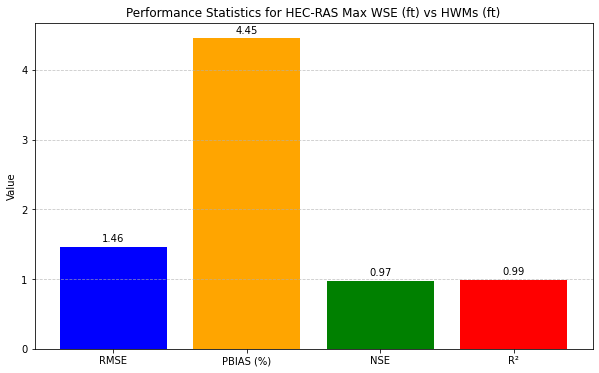

In [6]:
# Visualize the statistics
stats = {
    'RMSE': rmse,
    'PBIAS (%)': pbias,
    'NSE': nse,
    'R²': r2
}

# Create a bar plot for the statistics
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(stats.keys(), stats.values(), color=['blue', 'orange', 'green', 'red'])

# Adding titles and labels
plt.title('Performance Statistics for HEC-RAS Max WSE (ft) vs HWMs (ft)')
plt.ylabel('Value')

# Adding data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points", ha='center', va='bottom')

# Show the plot
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


## Gage time series analysis for Harvey

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Load the CSV file
file_path = "S:\For_Angshuman\GLO\HEC-RASV6.5_NewBaseModel\HECRASV6.5_BaseModel\Harvey_Gage_RAS_Simulation_data.csv"
df = pd.read_csv(file_path)

# Extract the observed and simulated values
observed = df['Observed Water Surface Elevation (ft)'].values
simulated = df['Simulated Water Surface Elevation (ft)'].values

# Filter out rows where observed or simulated values are NaN
valid_indices = ~np.isnan(observed) & ~np.isnan(simulated)
observed = observed[valid_indices]
simulated = simulated[valid_indices]

# Calculate RMSE
rmse = np.sqrt(np.mean((observed - simulated) ** 2))

# Calculate PBIAS
pbias = 100 * (np.sum(observed - simulated) / np.sum(observed))

# Calculate NSE
nse = 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

# Fit the linear regression model for R² calculation
model = LinearRegression()
model.fit(simulated.reshape(-1, 1), observed)

# Get the predicted values from the linear regression
observed_pred = model.predict(simulated.reshape(-1, 1))

# Calculate the R² value
r2 = r2_score(observed, observed_pred)

# Calculate Min difference, Max difference, Mean difference, and Standard Deviation of difference
differences = observed - simulated
min_diff = np.min(differences)
max_diff = np.max(differences)
mean_diff = np.mean(differences)
std_diff = np.std(differences)

# Print calculated statistics
print(f"RMSE: {rmse:.2f}")
print(f"PBIAS: {pbias:.2f}%")
print(f"NSE: {nse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Min Difference (Observed - Simulated) ft: {min_diff:.2f}")
print(f"Max Difference (Observed - Simulated) ft: {max_diff:.2f}")
print(f"Mean Difference (Observed - Simulated) ft: {mean_diff:.2f}")
print(f"Standard Deviation of Difference (Observed - Simulated) ft: {std_diff:.2f}")


RMSE: 1.87
PBIAS: -30.37%
NSE: -0.30
R²: 0.68
Min Difference (Observed - Simulated) ft: -3.44
Max Difference (Observed - Simulated) ft: 2.04
Mean Difference (Observed - Simulated) ft: -1.56
Standard Deviation of Difference (Observed - Simulated) ft: 1.03


RMSE: 1.87
PBIAS: -30.37%
NSE: -0.30
R²: 0.68
Min Difference (Observed - Simulated) ft: -3.44
Max Difference (Observed - Simulated) ft: 2.04
Mean Difference (Observed - Simulated) ft: -1.56
Standard Deviation of Difference (Observed - Simulated) ft: 1.03


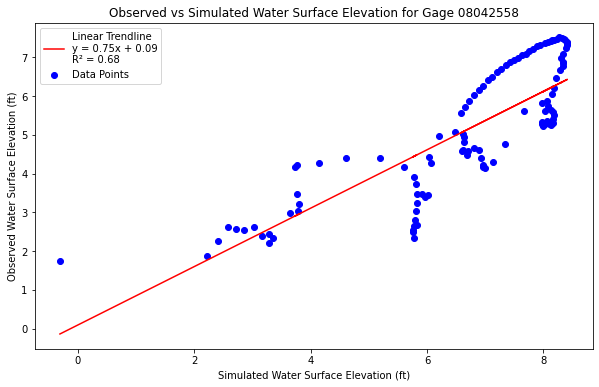

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "S:\For_Angshuman\GLO\HEC-RASV6.5_NewBaseModel\HECRASV6.5_BaseModel\Harvey_Gage_RAS_Simulation_data.csv"
df = pd.read_csv(file_path)

# Extract the observed and simulated values
observed = df['Observed Water Surface Elevation (ft)'].values
simulated = df['Simulated Water Surface Elevation (ft)'].values

# Filter out rows where observed or simulated values are NaN
valid_indices = ~np.isnan(observed) & ~np.isnan(simulated)
observed = observed[valid_indices]
simulated = simulated[valid_indices]

# Calculate RMSE
rmse = np.sqrt(np.mean((observed - simulated) ** 2))

# Calculate PBIAS
pbias = 100 * (np.sum(observed - simulated) / np.sum(observed))

# Calculate NSE
nse = 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

# Fit the linear regression model for R² calculation
model = LinearRegression()
model.fit(simulated.reshape(-1, 1), observed)

# Get the predicted values from the linear regression
observed_pred = model.predict(simulated.reshape(-1, 1))

# Calculate the R² value
r2 = r2_score(observed, observed_pred)

# Calculate Min difference, Max difference, Mean difference, and Standard Deviation of difference
differences = observed - simulated
min_diff = np.min(differences)
max_diff = np.max(differences)
mean_diff = np.mean(differences)
std_diff = np.std(differences)

# Print calculated statistics
print(f"RMSE: {rmse:.2f}")
print(f"PBIAS: {pbias:.2f}%")
print(f"NSE: {nse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Min Difference (Observed - Simulated) ft: {min_diff:.2f}")
print(f"Max Difference (Observed - Simulated) ft: {max_diff:.2f}")
print(f"Mean Difference (Observed - Simulated) ft: {mean_diff:.2f}")
print(f"Standard Deviation of Difference (Observed - Simulated) ft: {std_diff:.2f}")

# Plot observed vs. simulated
plt.figure(figsize=(10, 6))
plt.scatter(simulated, observed, label='Data Points', color='blue')
plt.plot(simulated, observed_pred, color='red', label=f'Linear Trendline\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}\nR² = {r2:.2f}')
plt.title('Observed vs Simulated Water Surface Elevation for Gage 08042558')
plt.xlabel('Simulated Water Surface Elevation (ft)')
plt.ylabel('Observed Water Surface Elevation (ft)')
plt.legend()
plt.grid(False)
plt.show()


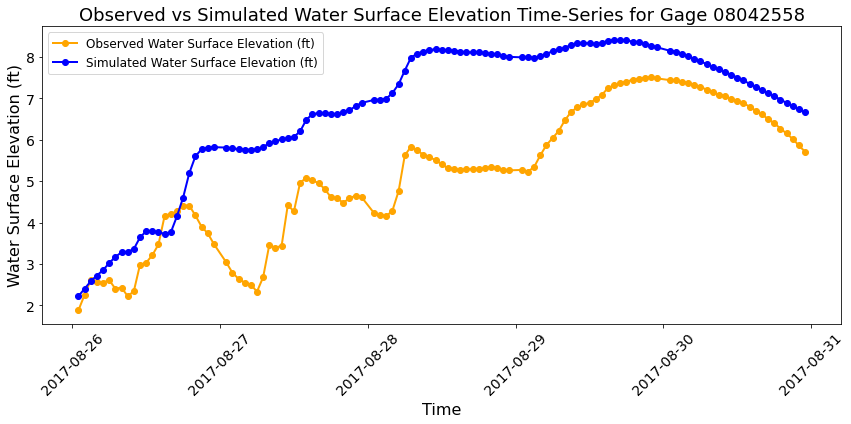

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "S:\For_Angshuman\GLO\HEC-RASV6.5_NewBaseModel\HECRASV6.5_BaseModel\Harvey_Gage_RAS_Simulation_data.csv"
df = pd.read_csv(file_path)

# Function to clean date strings
def clean_date_string(date_str):
    return date_str.strip().replace('  ', ' ')

# Apply the function to clean date strings
df['Time and Date'] = df['Time and Date'].apply(clean_date_string)

# Convert the 'Time and Date' column to datetime
df['Time and Date'] = pd.to_datetime(df['Time and Date'], format='%d%b%Y %H%M', errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['Time and Date'])

# Extract the observed and simulated values along with the time
time = df['Time and Date'].values
observed = df['Observed Water Surface Elevation (ft)'].values
simulated = df['Simulated Water Surface Elevation (ft)'].values

# Filter out rows where observed or simulated values are NaN
valid_indices = ~np.isnan(observed) & ~np.isnan(simulated)
time = time[valid_indices]
observed = observed[valid_indices]
simulated = simulated[valid_indices]

# Plot both time-series
plt.figure(figsize=(12, 6))

# Plot observed water surface elevation
plt.plot(time, observed, label='Observed Water Surface Elevation (ft)', marker='o', linestyle='-', color='orange', markersize=6, linewidth=2)

# Plot simulated water surface elevation
plt.plot(time, simulated, label='Simulated Water Surface Elevation (ft)', marker='o', linestyle='-', color='blue', markersize=6, linewidth=2)

# Adding titles and labels
plt.title('Observed vs Simulated Water Surface Elevation Time-Series for Gage 08042558', fontsize=18)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Water Surface Elevation (ft)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(False)


# Improve x-axis and y-axis tick labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()
